# Correlated-Feature Demo: Model Zoo, SHAP (with clustering), and Scaling Ablations

This notebook builds a **spatially structured, correlation-controlled** synthetic dataset and lets you:

- **Select which features** to train on.
- **Choose one or many models** from a model zoo (Linear, Kernel, Trees/Ensembles, MLP, optional XGBoost & Symbolic Regression).
- **Run SHAP** (with correlation-aware clustered bars).
- **Compare scalers** (Standardize vs MinMax vs Raw) via a **scaling ablation** on a chosen model.

We also:
- Show the **ground-truth feature correlation** (from the generator) vs empirical correlation.
- Compare **SHAP’s correlation clustering** to ground truth, reporting ARI and a best cutoff.

> **Quick start:** Run the “Install & Imports” cell, then the **“Config: choose features & models”** cell, and finally **“Train + Evaluate Selected Models”**.


In [ ]:
# If running in Colab, this ensures optional libs exist
!pip -q install gplearn shap xgboost

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from math import ceil
from scipy.ndimage import gaussian_filter

# sklearn basics
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# optional libraries (guarded)
try:
    from xgboost import XGBRegressor
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

try:
    from gplearn.genetic import SymbolicRegressor
    _HAS_GPLEARN = True
except Exception:
    _HAS_GPLEARN = False

import shap
import itertools
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score

RNG = 7
np.random.seed(RNG)

# plotting defaults
plt.rcParams["figure.dpi"] = 120
sns.set_context("talk")


## Dataset generator: spatial + correlated blocks

We create smooth spatial feature maps with:
- **Correlated blocks** (e.g., `x0,x1,x2` with ρ=0.85; `x3,x4` with ρ=0.75).
- **Independent features** (`x5,x6`) that are orthogonal to the correlated group fields.
- A **target** (choose among `linear`, `quad_sin`, `interaction`, `symbolic`) plus noise.

You can visualize feature maps and the correlation heatmap.


In [ ]:
rng = np.random.default_rng(123)

def _smooth(Z, sigma):
    return gaussian_filter(Z, sigma=sigma, mode="reflect") if sigma and sigma>0 else Z

def _standardize(A, eps=1e-12):
    A = A.astype(float)
    return (A - A.mean()) / (A.std() + eps)

def _flatten(Z):  # (ny,nx) -> (ny*nx,)
    return Z.reshape(-1)

def _proj_out(v, basis):
    """Remove components of v along all basis columns (least-squares)."""
    if basis.size == 0:
        return v
    BtB = basis.T @ basis
    coef = np.linalg.pinv(BtB) @ (basis.T @ v)
    return v - basis @ coef

def make_spatial_mixed(
    ny=28, nx=28, d=7,
    groups=([[0,1,2],[3,4]]),
    rhos=(0.85, 0.75),
    independent_idxs=(5,6),
    spatial_sigma=3.0,
    target_kind="quad_sin",
    noise_sigma=0.25,
    seed=42
):
    rng = np.random.default_rng(seed)
    assert len(groups) == len(rhos), "rhos must match number of groups"
    assert max([i for g in groups for i in g] + list(independent_idxs)) < d, "index out of range"

    # 1) shared field per group
    ny, nx = int(ny), int(nx)
    group_shared = []
    for _ in groups:
        gfield = _standardize(_smooth(rng.normal(size=(ny,nx)), spatial_sigma))
        group_shared.append(gfield)

    # 2) construct each feature
    X_maps = [None]*d
    for gid, g in enumerate(groups):
        a = np.sqrt(max(0.0, rhos[gid])); b = np.sqrt(max(0.0, 1.0 - rhos[gid]))
        G = group_shared[gid]
        for j in g:
            Ej = _standardize(_smooth(rng.normal(size=(ny,nx)), spatial_sigma))
            X_maps[j] = _standardize(a*G + b*Ej)

    # 3) independent features orthogonal to group fields
    if len(independent_idxs) > 0:
        basis = np.column_stack([_flatten(_standardize(gs)) for gs in group_shared]) if group_shared else np.empty((ny*nx, 0))
        for j in independent_idxs:
            raw = _flatten(_standardize(_smooth(rng.normal(size=(ny,nx)), spatial_sigma)))
            clean = _proj_out(raw, basis)
            clean = (clean - clean.mean()) / (clean.std() + 1e-12)
            X_maps[j] = clean.reshape(ny, nx)

    # 4) fill any leftovers with smooth random
    covered = set(independent_idxs) | set([k for g in groups for k in g])
    for j in range(d):
        if X_maps[j] is None:
            X_maps[j] = _standardize(_smooth(rng.normal(size=(ny,nx)), spatial_sigma))

    X_stack = np.stack(X_maps, axis=2)

    # 5) target
    def _target(Xs, kind="quad_sin"):
        if kind == "linear":
            w = np.linspace(1.0, 0.2, Xs.shape[2])
            return np.tensordot(Xs, w, axes=([2],[0]))
        if kind == "quad_sin":
            X = Xs if Xs.shape[2] >= 3 else np.pad(Xs, ((0,0),(0,0),(0,3-Xs.shape[2])), mode='constant')
            return 1.5*(X[:,:,0]**2) + np.sin(X[:,:,1]) + 0.5*X[:,:,2]
        if kind == "interaction":
            X = Xs if Xs.shape[2] >= 4 else np.pad(Xs, ((0,0),(0,0),(0,4-Xs.shape[2])), mode='constant')
            return X[:,:,0]*X[:,:,1] + 0.7*X[:,:,2] - 0.5*X[:,:,3]
        if kind == "symbolic":
            X = Xs if Xs.shape[2] >= 3 else np.pad(Xs, ((0,0),(0,0),(0,3-Xs.shape[2])), mode='constant')
            return np.exp(-X[:,:,0]) * np.cos(X[:,:,1]) + 0.2*X[:,:,2]
        return Xs[:,:,0]

    f_map = _target(X_stack, "quad_sin")
    y_map = f_map + rng.normal(0, 0.25, size=(ny, nx))

    cols = [f"x{i}" for i in range(d)]
    df = pd.DataFrame(
        np.column_stack([X_stack[:,:,i].ravel() for i in range(d)] + [y_map.ravel()]),
        columns=cols + ["Target"]
    )
    rr, cc = np.indices((ny, nx)); df["row"] = rr.ravel(); df["col"] = cc.ravel()

    meta = dict(n=ny*nx, d=d, ny=ny, nx=nx, groups=groups, rhos=rhos,
                independent=list(independent_idxs), spatial_sigma=spatial_sigma,
                target_kind="quad_sin")
    return df, meta, X_stack, y_map

def plot_maps(X_stack, y_map, title_prefix="Feature • "):
    ny, nx, d = X_stack.shape
    k = d + 1
    ncols = 4
    nrows = int(ceil(k / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.8*nrows))
    axes = np.atleast_2d(axes).ravel()
    for j in range(d):
        im = axes[j].imshow(X_stack[:,:,j], origin="upper", cmap="viridis")
        axes[j].set_title(f"{title_prefix}x{j}")
        axes[j].set_xticks([]); axes[j].set_yticks([])
        plt.colorbar(im, ax=axes[j], fraction=0.046, pad=0.04)
    im = axes[d].imshow(y_map, origin="upper", cmap="viridis")
    axes[d].set_title("Target"); axes[d].set_xticks([]); axes[d].set_yticks([])
    plt.colorbar(im, ax=axes[d], fraction=0.046, pad=0.04)
    for ax in axes[k:]: ax.axis("off")
    plt.tight_layout(); plt.show()

def correlation_heatmap(df, title="Feature×Feature correlation"):
    xcols = [c for c in df.columns if c.startswith("x")]
    C = df[xcols].corr().to_numpy()
    fig, ax = plt.subplots(figsize=(5.4,4.8))
    im = ax.imshow(C, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_xticks(range(len(xcols))); ax.set_yticks(range(len(xcols)))
    ax.set_xticklabels(xcols, rotation=45, ha="right"); ax.set_yticklabels(xcols)
    ax.set_title(title); plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()


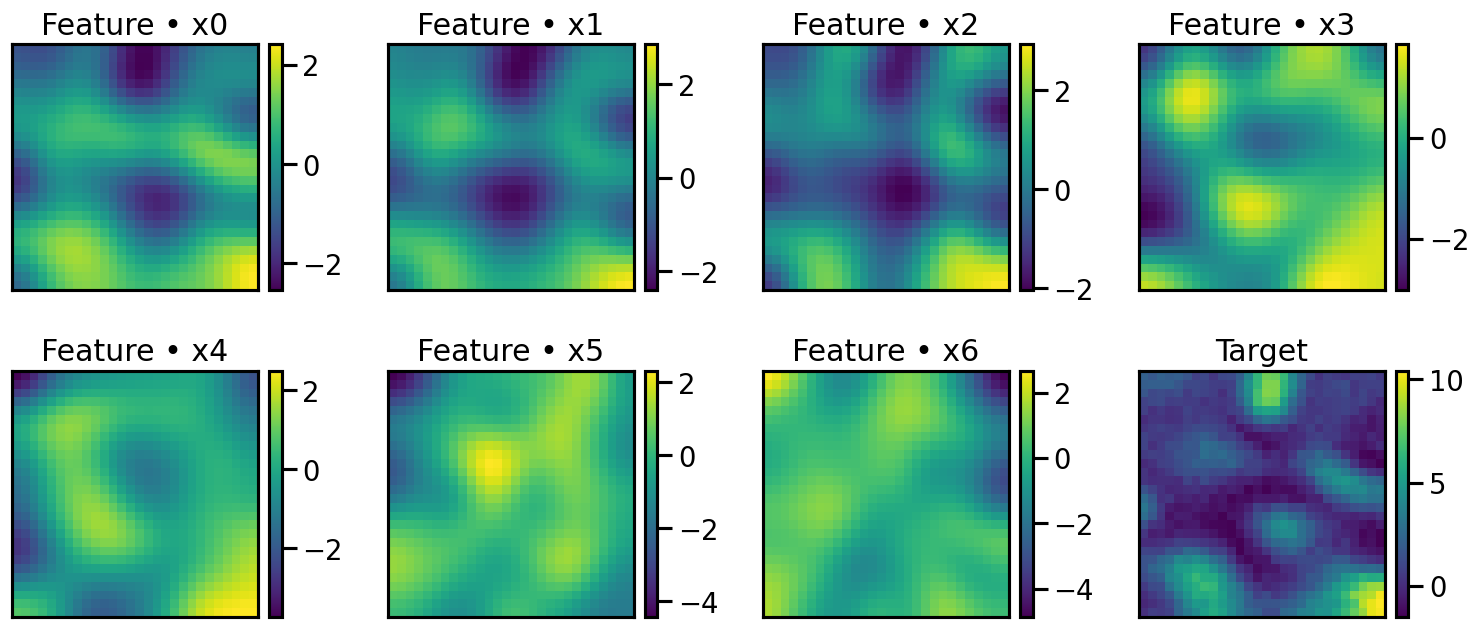

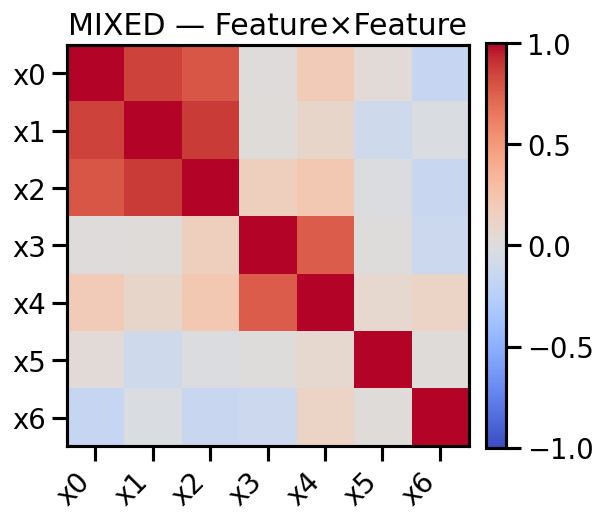

Ground-truth correlated blocks: [[0, 1, 2], [3, 4]] with rhos (0.85, 0.75) | independent: [5, 6]


In [ ]:
df_mix, meta_mix, X_mix, y_mix = make_spatial_mixed(
    ny=28, nx=28, d=7,
    groups=[[0,1,2],[3,4]],     # correlated blocks
    rhos=(0.85, 0.75),
    independent_idxs=(5,6),
    spatial_sigma=3.0,
    target_kind="quad_sin",
    noise_sigma=0.25,
    seed=7
)

plot_maps(X_mix, y_mix, title_prefix="Feature • ")
correlation_heatmap(df_mix, title="MIXED — Feature×Feature")
print("Ground-truth correlated blocks:", meta_mix["groups"], "with rhos", meta_mix["rhos"],
      "| independent:", meta_mix["independent"])


In [ ]:
#Helper Utilities
def make_Xy(df, feature_names, ycol="y"):
    X = df[feature_names].to_numpy(dtype=float)
    y = df[ycol].to_numpy(dtype=float)
    return X, y

def _scores(y_true, y_pred):
    return dict(
        R2=float(r2_score(y_true, y_pred)),
        RMSE=float(np.sqrt(mean_squared_error(y_true, y_pred))),
        MAE=float(mean_absolute_error(y_true, y_pred)),
    )

def summarize_winners(leaderboard, best_models):
    rows = []
    for m in leaderboard["model"]:
        est = best_models[m]
        params = est.get_params() if hasattr(est, "get_params") else {}
        rows.append({"model": m, "best_estimator_type": type(est).__name__, "n_params": len(params)})
    return pd.DataFrame(rows)


In [ ]:
def build_model_zoo(random_state=RNG):
    zoo = {}

    # Linear family
    zoo["Linear"] = (
        Pipeline([("scaler", StandardScaler()), ("m", LinearRegression())]),
        {"scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]}
    )
    zoo["Ridge"] = (
        Pipeline([("scaler", StandardScaler()), ("m", Ridge(random_state=random_state))]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__alpha": np.logspace(-4, 3, 50)}
    )
    zoo["Lasso"] = (
        Pipeline([("scaler", StandardScaler()), ("m", Lasso(random_state=random_state, max_iter=10000))]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__alpha": np.logspace(-4, 1, 50)}
    )
    zoo["ElasticNet"] = (
        Pipeline([("scaler", StandardScaler()), ("m", ElasticNet(random_state=random_state, max_iter=10000))]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__alpha": np.logspace(-4, 1, 50),
         "m__l1_ratio": np.linspace(0.05, 0.95, 19)}
    )

    # Kernel / neighbors
    zoo["SVR-RBF"] = (
        Pipeline([("scaler", StandardScaler()), ("m", SVR(kernel="rbf"))]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__C":     np.logspace(-2, 3, 30),
         "m__gamma": np.logspace(-4, 1, 30),
         "m__epsilon": np.logspace(-3, 0, 15)}
    )
    zoo["KNN"] = (
        Pipeline([("scaler", StandardScaler()), ("m", KNeighborsRegressor())]),
        {"scaler":[StandardScaler(), RobustScaler(), MinMaxScaler()],
         "m__n_neighbors": list(range(3, 41, 2)),
         "m__weights": ["uniform", "distance"],
         "m__p": [1, 2]}
    )

    # Trees / ensembles
    zoo["RF"] = (
        RandomForestRegressor(n_estimators=500, random_state=random_state, n_jobs=-1),
        {"max_depth":[None]+list(range(3,31,3)),
         "min_samples_split":[2,5,10],
         "min_samples_leaf":[1,2,4],
         "max_features":["sqrt","log2",None]}
    )
    zoo["ExtraTrees"] = (
        ExtraTreesRegressor(n_estimators=600, random_state=random_state, n_jobs=-1),
        {"max_depth":[None]+list(range(3,31,3)),
         "min_samples_split":[2,5,10],
         "min_samples_leaf":[1,2,4],
         "max_features":["sqrt","log2",None]}
    )
    zoo["GBDT"] = (
        GradientBoostingRegressor(random_state=random_state),
        {"n_estimators":[200,300,500,800],
         "learning_rate": np.logspace(-3, -0.3, 10),
         "max_depth":[2,3,4,5],
         "subsample":[0.6,0.8,1.0],
         "min_samples_leaf":[1,2,4]}
    )
    zoo["HGBDT"] = (
        HistGradientBoostingRegressor(random_state=random_state),
        {"learning_rate": np.logspace(-3, -0.3, 10),
         "max_depth":[None,4,6,8,12],
         "l2_regularization": np.logspace(-6, 1, 10)}
    )

    # MLP
    zoo["MLP"] = (
        Pipeline([("scaler", StandardScaler()),
                  ("m", MLPRegressor(max_iter=800, early_stopping=True, random_state=random_state))]),
        {"scaler":[StandardScaler(), RobustScaler()],
         "m__hidden_layer_sizes":[(64,64),(128,64),(128,128),(256,128),(64,64,32)],
         "m__activation":["relu","tanh"],
         "m__alpha": np.logspace(-6, -2, 10),
         "m__learning_rate_init": np.logspace(-4, -2, 6),
         "m__batch_size":[32,64,128]}
    )

    if _HAS_XGB:
        zoo["XGB"] = (
            XGBRegressor(n_estimators=1200, random_state=random_state, n_jobs=-1,
                         tree_method="hist", reg_lambda=1.0, reg_alpha=0.0),
            {"max_depth":[3,4,5,6,8],
             "learning_rate": np.logspace(-3, -0.2, 12),
             "subsample":[0.6,0.8,1.0],
             "colsample_bytree":[0.6,0.8,1.0],
             "min_child_weight":[1,5,10],
             "gamma":[0.0,0.1,0.2]}
        )

    if _HAS_GPLEARN:
        # Choose a VALID fixed mutation/crossover budget (sum ≤ 1.0)
        SYMREG_PROBS = dict(
            p_crossover=0.60,
            p_subtree_mutation=0.20,
            p_hoist_mutation=0.05,
            p_point_mutation=0.10,  # total = 0.95
        )

        zoo["SymReg"] = (
            SymbolicRegressor(
                population_size=1200,
                generations=20,
                tournament_size=20,
                stopping_criteria=0.0,
                function_set=("add","sub","mul","div","sin","cos","sqrt","log"),
                metric="mean absolute error",
                max_samples=0.9,
                parsimony_coefficient=1e-4,
                n_jobs=-1,
                verbose=0,
                random_state=random_state,
                **SYMREG_PROBS
            ),
            # Only search *safe* parameters
            {
                "population_size": [600, 900, 1200, 1500],
                "generations": [15, 20, 30],
                "tournament_size": [10, 20, 30],
                "parsimony_coefficient": np.logspace(-6, -3, 4),
                "function_set": [
                    ("add","sub","mul","div","sin","cos","sqrt","log"),
                    ("add","sub","mul","div","sin","cos","sqrt"),
                    ("add","sub","mul","div","sqrt","log"),
                ],
                # (Intentionally NOT sampling the p_* probabilities)
            }
        )
    return zoo


## Config: choose features & models to run

- Pick the **feature set** (any subset of `x0..x6`).
- Pick **one or more models** to train/evaluate.
- Choose **CV budget** and whether to **show SHAP** & **clustered bars**.


### Cross-Validation (CV) — and How to Choose “CV splits”

**What is CV?**  
Cross-validation is a way to estimate how well a model will generalize to new data. We repeatedly:
1) split the **training** data into *K* equal pieces (“folds”),  
2) train on K−1 folds, test on the 1 fold left out,  
3) rotate so each fold is the test once, then average the K test scores.

That averaged score is more reliable than a single train/validation split.

---

### What does “CV splits” mean?
It’s the number of folds **K**.  
- **K = 5** (aka “5-fold CV”) → a strong default in practice.  
- The higher K is, the more repeats → slower but slightly more stable estimates.

---

### How to choose K (quick guide)

- **Exploration / fast runs:** **3 folds**  
  *Why:* ~40% fewer fits than 5-fold; good when you’re iterating quickly.

- **Default / balanced:** **5 folds**  
  *Why:* Common trade-off between speed and stability; use for most comparisons.

- **Final check (more stability):** **10 folds**  
  *Why:* Slightly tighter estimate; expect ~2× runtime vs 5-fold.

> **Rule of thumb:** Start with **3** while prototyping, switch to **5** when results look reasonable, and only use **10** if you need extra precision.

---

### Runtime intuition
Hyperparameter search does **(#models tried) × (CV splits)** fits.  
Reducing `CV splits` from 5 → 3 cuts training time by ~40%.

---

### When CV can mislead (and what to do)
- **Spatial or clustered data (our synthetic maps!)**: nearby points are similar, so random CV can be optimistic.  
  **Better:** use *blocked* CV (keep spatial neighborhoods together) or `GroupKFold` with location-based groups.
- **Very small datasets (<~100 samples):** higher K (e.g., 10) can help use data more efficiently.
- **Highly imbalanced targets/classes:** use stratified variants when applicable.

---

### Practical tips for this notebook
- If runs are slow: set **CV splits = 3** and **reduce n_iter** for the search.  
- After picking a promising model, rerun once with **CV splits = 5** to report results.  
- Keep the test set separate; CV happens only on the training split during tuning.



In [ ]:
from ipywidgets import widgets, Layout, HBox, VBox

all_features = [c for c in df_mix.columns if c.startswith("x")]
feature_select = widgets.SelectMultiple(
    options=all_features, value=tuple(all_features), description='Features', layout=Layout(width='250px', height='160px')
)

zoo = build_model_zoo(RNG)
model_options = list(zoo.keys())
model_select = widgets.SelectMultiple(
    options=model_options,
    value=("SVR-RBF","RF","MLP"),
    description='Models',
    layout=Layout(width='250px', height='160px')
)

cv_splits_w = widgets.IntSlider(value=5, min=3, max=10, step=1, description='CV splits')
n_iter_w    = widgets.IntSlider(value=35, min=5, max=200, step=5, description='RandomizedSearch iters')

show_shap_w = widgets.Checkbox(value=True, description='Show SHAP')
show_clustered_bar_w = widgets.Checkbox(value=True, description='Clustered SHAP bars')

ui = HBox([
    feature_select,
    VBox([model_select, cv_splits_w, n_iter_w, show_shap_w, show_clustered_bar_w])
])
ui


In [ ]:
# build X,y using selected features
chosen_features = list(feature_select.value)
X, y = make_Xy(df_mix, chosen_features, ycol="Target")

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=RNG)
xcols = chosen_features[:]  # for SHAP labeling

print(f"Using features: {xcols}")
print("Train/Test shapes:", Xtr.shape, Xte.shape)


Using features: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
Train/Test shapes: (627, 7) (157, 7)


## Train + Evaluate selected models

We run a `RandomizedSearchCV` per selected model with the chosen CV & iteration budget.
A **leaderboard** (TEST set) is printed and the **best model plot** (Pred vs True).


SVR-RBF: best CV R2=0.984 | TEST {'R2':0.988, 'RMSE':0.241, 'MAE':0.188}
RF: best CV R2=0.973 | TEST {'R2':0.983, 'RMSE':0.292, 'MAE':0.237}
MLP: best CV R2=0.981 | TEST {'R2':0.982, 'RMSE':0.294, 'MAE':0.221}

=== Leaderboard (TEST set) ===


,model,R2,RMSE,MAE,best_params
0,SVR-RBF,0.988114,0.241056,0.187938,"{'scaler': RobustScaler(), 'm__gamma': 0.01172..."
1,RF,0.982571,0.291903,0.236585,"{'min_samples_split': 2, 'min_samples_leaf': 1..."
2,MLP,0.982284,0.294300,0.221059,"{'scaler': RobustScaler(), 'm__learning_rate_i..."


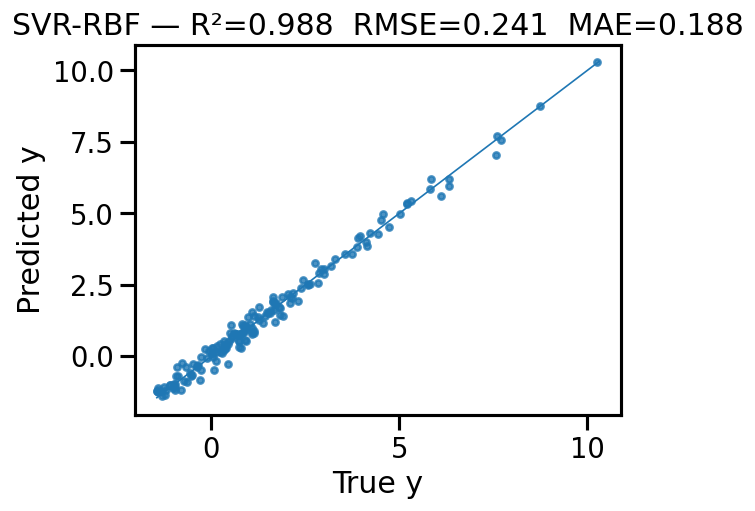

In [ ]:
def run_model_search_subset(Xtr, Xte, ytr, yte, xcols, selected_models, cv_splits=5, n_iter=35, random_state=RNG, n_jobs=-1, verbose=0):
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    zoo = build_model_zoo(random_state)
    results, best_models = [], {}

    for name in selected_models:
        estimator, param_dist = zoo[name]
        rs = RandomizedSearchCV(
            estimator, param_distributions=param_dist, n_iter=n_iter, cv=cv,
            scoring="r2", n_jobs=n_jobs, random_state=random_state, verbose=verbose, refit=True
        )
        rs.fit(Xtr, ytr)
        yhat = rs.best_estimator_.predict(Xte)
        s = _scores(yte, yhat)
        s.update(dict(model=name, best_params=rs.best_params_))
        results.append(s)
        best_models[name] = rs.best_estimator_
        print(f"{name}: best CV R2={rs.best_score_:.3f} | TEST {{'R2':{s['R2']:.3f}, 'RMSE':{s['RMSE']:.3f}, 'MAE':{s['MAE']:.3f}}}")

    leaderboard = pd.DataFrame(results).sort_values("R2", ascending=False).reset_index(drop=True)
    return leaderboard, best_models

leaderboard, best_models = run_model_search_subset(
    Xtr, Xte, ytr, yte, xcols,
    selected_models=list(model_select.value),
    cv_splits=cv_splits_w.value,
    n_iter=n_iter_w.value,
    verbose=0
)

print("\n=== Leaderboard (TEST set) ===")
display(leaderboard[["model","R2","RMSE","MAE","best_params"]])
best_name = leaderboard.iloc[0]["model"]; best_est = best_models[best_name]

# quick best-model plot
yhat = best_est.predict(Xte)
s = _scores(yte, yhat)
plt.figure(figsize=(5.4, 4.6))
plt.scatter(yte, yhat, s=14, alpha=0.8)
lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
plt.plot(lims, lims, lw=1)
plt.xlabel("True y"); plt.ylabel("Predicted y")
plt.title(f"{best_name} — R²={s['R2']:.3f}  RMSE={s['RMSE']:.3f}  MAE={s['MAE']:.3f}")
plt.tight_layout(); plt.show()


## SHAP summaries (+ clustered bars)

- Linear models → `shap.LinearExplainer` (work in scaled space, plot vs raw X).
- Tree/Ensemble models → `shap.TreeExplainer` (interventional).
- SVR/KNN/MLP/Symbolic → `shap.KernelExplainer` (black-box).


SHAP helper functions

In [ ]:
def _unwrap_estimator(est):
    if isinstance(est, Pipeline):
        scaler = est.named_steps.get("scaler", None)
        model  = est.named_steps.get("m", None)
        if model is None:
            last_key = list(est.named_steps.keys())[-1]
            model = est.named_steps[last_key]
            first_key = list(est.named_steps.keys())[0]
            scaler = est.named_steps[first_key] if "scale" in first_key else None
        return model, scaler
    return est, None

def _predict_fn(model, scaler=None):
    if scaler is None: return model.predict
    return lambda XR: model.predict(scaler.transform(XR))

def _build_feature_clustering(X_train, y_train=None):
    try:
        return shap.utils.hclust(X_train, y_train)
    except TypeError:
        return shap.utils.hclust(X_train, metric="correlation")

def _to_explanation(shap_values, X_for_plot, feature_names):
    sv = shap_values[0] if isinstance(shap_values, list) else shap_values
    base = np.zeros(len(X_for_plot))
    return shap.Explanation(values=np.asarray(sv), base_values=base, data=X_for_plot, feature_names=feature_names)

def _clustered_bar(explanation, linkage, title, cutoff=1.0):
    drew = False
    try:
        fig, ax = plt.subplots(figsize=(6,4))
        shap.plots.bar(explanation, max_display=12, clustering=linkage, clustering_cutoff=float(cutoff))
        drew = len(ax.patches) > 0 or len(ax.containers) > 0
        if drew:
            ax.set_title(title); plt.tight_layout(); plt.show()
        else:
            plt.close(fig)
    except Exception:
        try: plt.close(fig)
        except Exception: pass
        drew = False

    if not drew:
        from scipy.cluster.hierarchy import fcluster
        sv = explanation.values
        mean_abs = np.mean(np.abs(sv), axis=0)
        clusters = fcluster(linkage, t=float(cutoff), criterion="distance")
        groups = {}
        for j, cid in enumerate(clusters): groups.setdefault(int(cid), []).append(j)
        vals, labels = [], []
        for cid, idxs in groups.items():
            vals.append(float(mean_abs[idxs].sum()))
            labels.append(explanation.feature_names[idxs[0]] if len(idxs)==1
                          else explanation.feature_names[idxs[0]]+f" (+{len(idxs)-1})")
        order = np.argsort(vals)[::-1]; vals = np.array(vals)[order]; labels = [labels[i] for i in order]
        y = np.arange(len(labels))
        plt.figure(figsize=(6, max(3, 0.35*len(labels))))
        plt.barh(y, vals); plt.yticks(y, labels); plt.gca().invert_yaxis()
        plt.xlabel("mean |SHAP| (grouped)"); plt.title(title); plt.tight_layout(); plt.show()



=== SVR-RBF ===


  0%|          | 0/157 [00:00<?, ?it/s]

/tmp/ipython-input-303789203.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xte, feature_names=xcols, show=False)


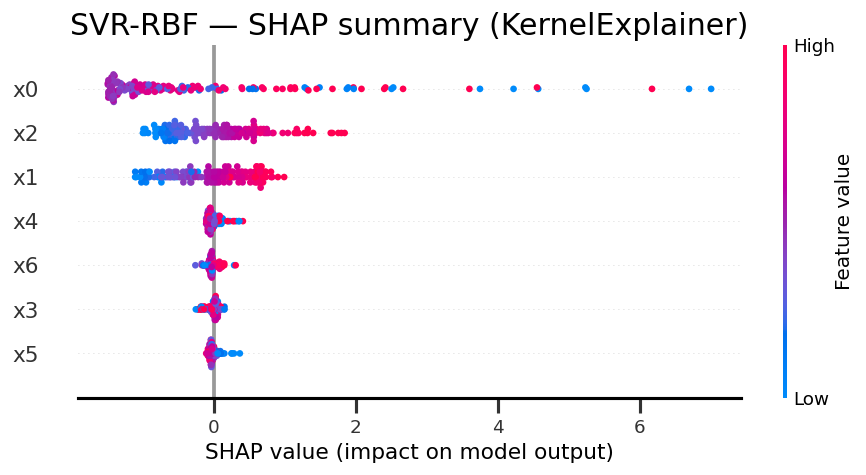

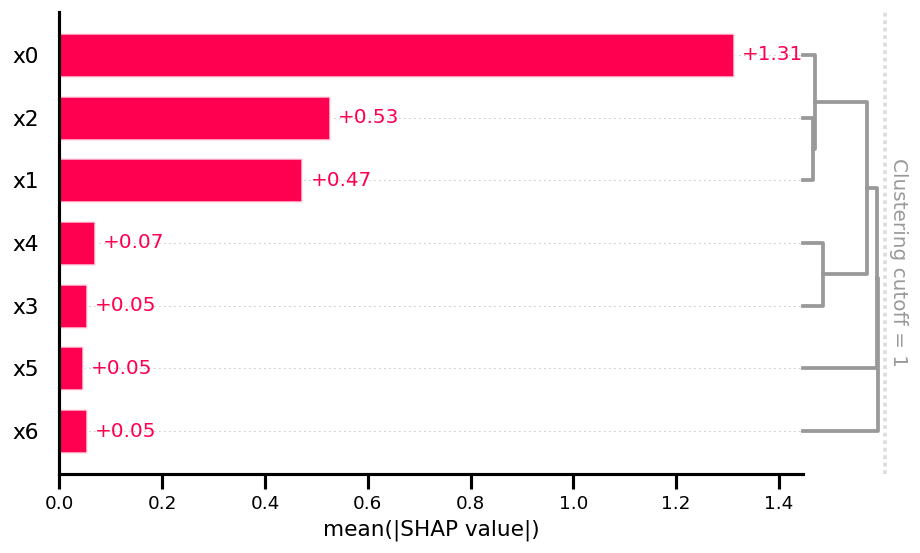

<Figure size 768x576 with 0 Axes>


=== RF ===


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(
/tmp/ipython-input-303789203.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xte, feature_names=xcols, show=False)


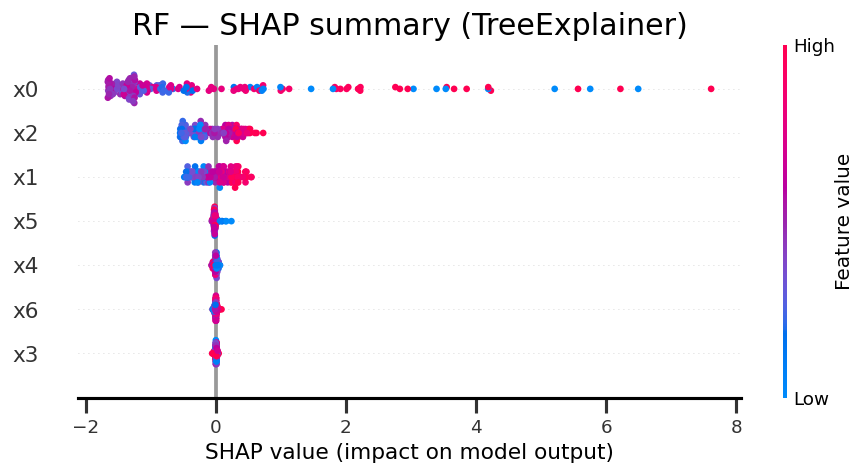

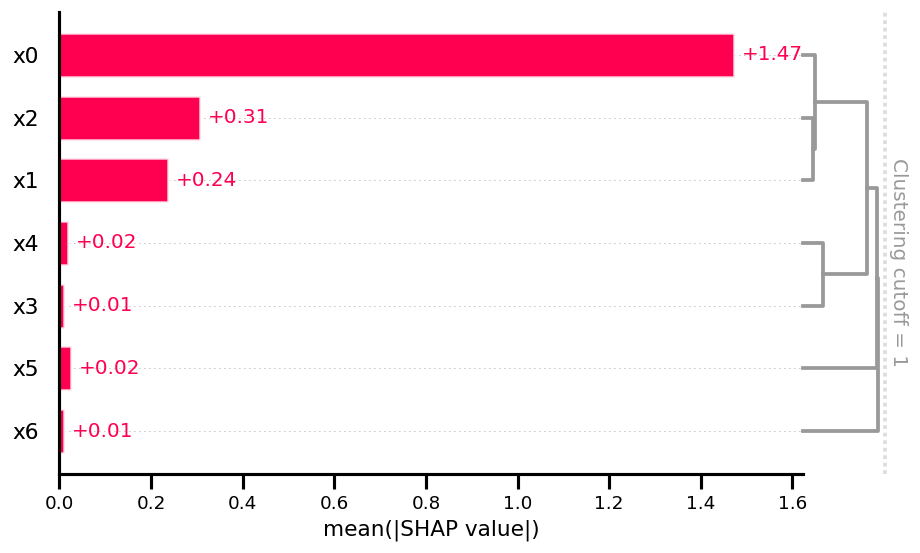

<Figure size 768x576 with 0 Axes>


=== MLP ===


  0%|          | 0/157 [00:00<?, ?it/s]

/tmp/ipython-input-303789203.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xte, feature_names=xcols, show=False)


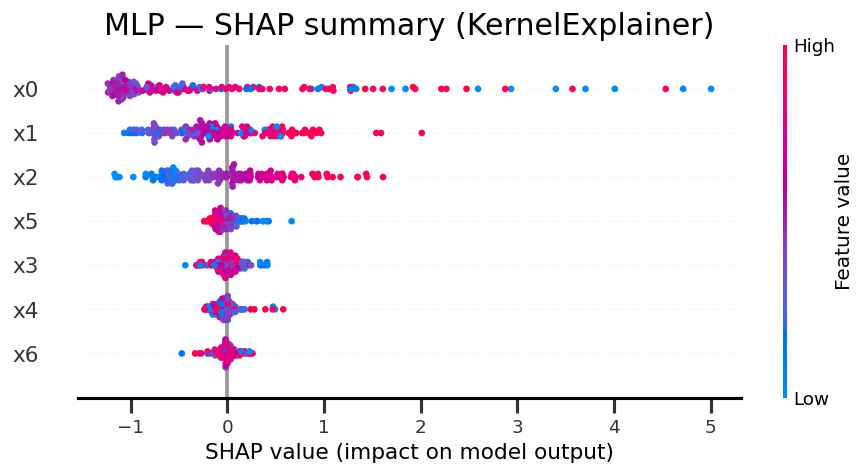

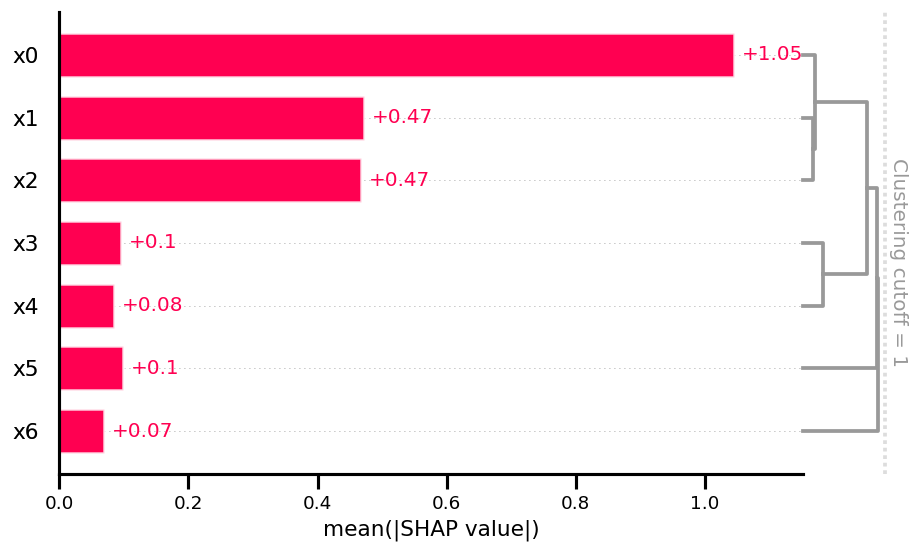

<Figure size 768x576 with 0 Axes>

In [ ]:
if show_shap_w.value:
    linkage_tree = _build_feature_clustering(Xtr) if show_clustered_bar_w.value else None

    for name, est in best_models.items():
        print(f"\n=== {name} ===")
        model, scaler = _unwrap_estimator(est)
        cls = model.__class__.__name__.lower()
        try:
            if any(k in cls for k in ["linearregression","ridge","lasso","elasticnet"]):
                Xtr_s = scaler.transform(Xtr) if scaler is not None else Xtr
                Xte_s = scaler.transform(Xte) if scaler is not None else Xte
                explainer = shap.LinearExplainer(model, Xtr_s, feature_names=xcols)
                sv = explainer.shap_values(Xte_s)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{name} — SHAP summary (LinearExplainer)"); plt.tight_layout(); plt.show()
                ex = _to_explanation(sv, Xte, xcols)

            elif any(k in cls for k in ["randomforest","extratrees","gradientboosting","histgradientboosting","xgbregressor"]):
                explainer = shap.TreeExplainer(model, feature_names=xcols, feature_perturbation="interventional", model_output="raw")
                sv = explainer.shap_values(Xte)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{name} — SHAP summary (TreeExplainer)"); plt.tight_layout(); plt.show()
                ex = _to_explanation(sv, Xte, xcols)

            else:
                f = _predict_fn(model, scaler=scaler)
                bg = Xtr if len(Xtr) <= 200 else Xtr[np.random.choice(len(Xtr), 200, replace=False)]
                explainer = shap.KernelExplainer(f, bg)
                sv = explainer.shap_values(Xte, nsamples=100)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{name} — SHAP summary (KernelExplainer)"); plt.tight_layout(); plt.show()
                ex = _to_explanation(sv, Xte, xcols)

            if show_clustered_bar_w.value and linkage_tree is not None:
                _clustered_bar(ex, linkage_tree, title=f"{name} — Clustered SHAP bar", cutoff=1.0)

        except Exception as e:
            print(f"SHAP failed for {name}: {e}")


## SHAP correlation clustering vs. ground truth

We compute **D = 1 − |corr|**, build dendrograms for **ground truth** and **SHAP’s correlation tree**, and scan cutoffs to report **best ARI**.


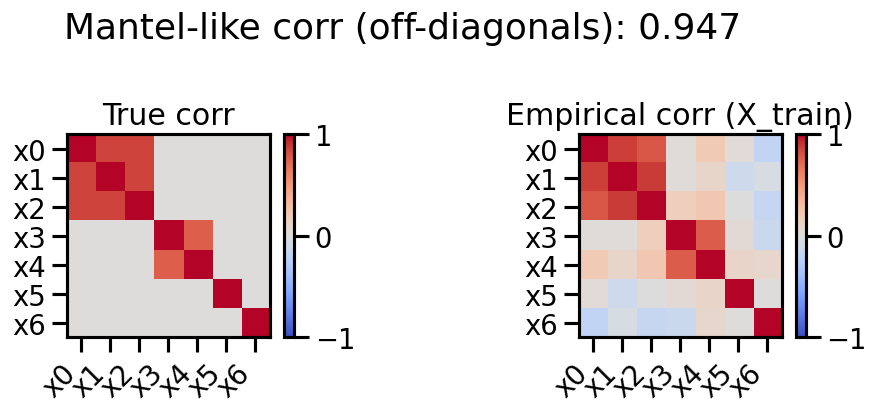

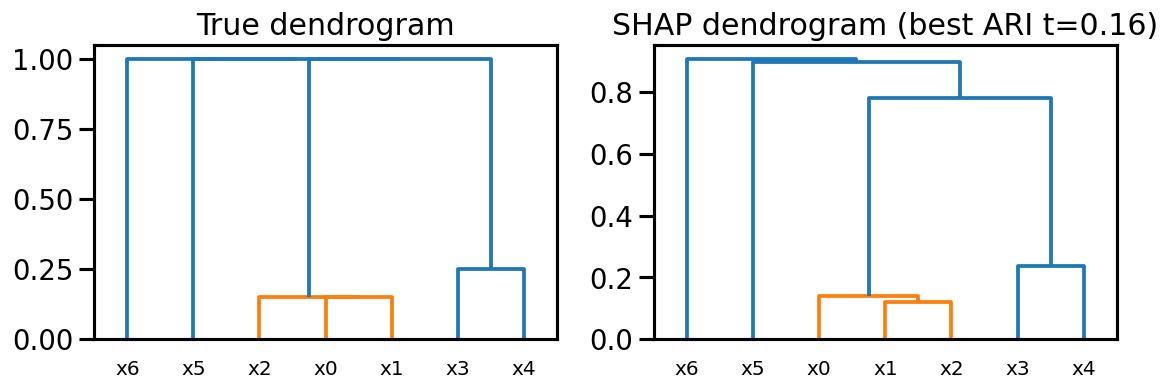

Similarity metrics:
  Mantel-like corr (C_true vs C_emp) = 0.947
  Best ARI (true vs SHAP clusters)   = 1.000 at cutoff t = 0.16


In [ ]:
def _true_corr_from_groups(d, groups, rhos):
    C = np.eye(d, dtype=float)
    for g, rho in zip(groups, rhos):
        for i,j in itertools.combinations(g, 2):
            C[i,j] = C[j,i] = float(rho)
    return C

def _mantel_like(A, B):
    iu = np.triu_indices_from(A, k=1)
    a, b = A[iu].ravel(), B[iu].ravel()
    den = np.std(a)*np.std(b)
    return float(np.corrcoef(a, b)[0,1]) if den>0 else np.nan

def compare_shap_corr_to_truth(Xtr, xcols, *, groups, rhos, cutoff_grid=None, method="average"):
    d = len(xcols)
    # map feature names to indices (assuming x0..x6)
    idx_map = {f"x{i}": i for i in range(d)}
    # re-create truth matrix for the selected subset by indices
    # here we assume the original plan: [[0,1,2],[3,4]], rhos as given
    C_true = _true_corr_from_groups(d, groups, rhos)
    C_emp  = np.corrcoef(Xtr, rowvar=False)
    D_true = 1 - np.abs(C_true)
    D_emp  = 1 - np.abs(C_emp)

    Z_true = linkage(squareform(D_true, checks=False), method=method)
    Z_shap = shap.utils.hclust(Xtr, metric="correlation")
    mantel = _mantel_like(C_true, C_emp)

    if cutoff_grid is None:
        heights = np.r_[Z_true[:,2], Z_shap[:,2]]
        lo, hi = float(np.min(heights)), float(np.max(heights))
        cutoff_grid = np.linspace(lo, hi, 25)

    best = (-1.0, None)
    for t in cutoff_grid:
        lab_true = fcluster(Z_true, t=float(t), criterion="distance")
        lab_shap = fcluster(Z_shap, t=float(t), criterion="distance")
        ari = adjusted_rand_score(lab_true, lab_shap)
        if ari > best[0]:
            best = (ari, t)
    best_ari, best_t = float(best[0]), float(best[1])

    fig, ax = plt.subplots(1,2, figsize=(8.8,3.6))
    im0 = ax[0].imshow(C_true, vmin=-1, vmax=1, cmap="coolwarm"); ax[0].set_title("True corr")
    ax[0].set_xticks(range(d)); ax[0].set_yticks(range(d))
    ax[0].set_xticklabels(xcols, rotation=45, ha="right"); ax[0].set_yticklabels(xcols)
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(C_emp, vmin=-1, vmax=1, cmap="coolwarm"); ax[1].set_title("Empirical corr (X_train)")
    ax[1].set_xticks(range(d)); ax[1].set_yticks(range(d))
    ax[1].set_xticklabels(xcols, rotation=45, ha="right"); ax[1].set_yticklabels(xcols)
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
    plt.suptitle(f"Mantel-like corr (off-diagonals): {mantel:.3f}")
    plt.tight_layout(); plt.show()

    fig, ax = plt.subplots(1,2, figsize=(9.6,3.6))
    dendrogram(Z_true, labels=xcols, ax=ax[0], color_threshold=best_t); ax[0].set_title("True dendrogram")
    dendrogram(Z_shap, labels=xcols, ax=ax[1], color_threshold=best_t); ax[1].set_title(f"SHAP dendrogram (best ARI t={best_t:.2f})")
    plt.tight_layout(); plt.show()

    print(f"Similarity metrics:\n  Mantel-like corr (C_true vs C_emp) = {mantel:.3f}\n  Best ARI (true vs SHAP clusters)   = {best_ari:.3f} at cutoff t = {best_t:.2f}")
    return dict(best_ari=best_ari, best_cutoff=best_t)

# only makes sense if you used contiguous x0..x6
d = len(xcols)
if xcols == [f"x{i}" for i in range(d)]:
    _ = compare_shap_corr_to_truth(
        Xtr, xcols,
        groups=[[0,1,2],[3,4]],
        rhos=[0.85, 0.75]
    )
else:
    print("Clustering comparison assumes x0..x6 order. Skip if you changed feature names/order.")


## Scaling ablation (per model)

Compare **Standardize(0,1)** vs **MinMax[0,1]** vs **Raw** for **one** chosen model
(SVR-RBF / Ridge / MLP). Optionally re-tune hyper-params per scaler.

> Use this to see how **scaling changes PD/SHAP** shape & importances.


[SVR-RBF | Standardize(0,1)] TEST: {'R2': -2.2912, 'RMSE': 4.0113, 'MAE': 2.8606}


  0%|          | 0/157 [00:00<?, ?it/s]

/tmp/ipython-input-552720587.py:97: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xte, feature_names=xcols, show=False)


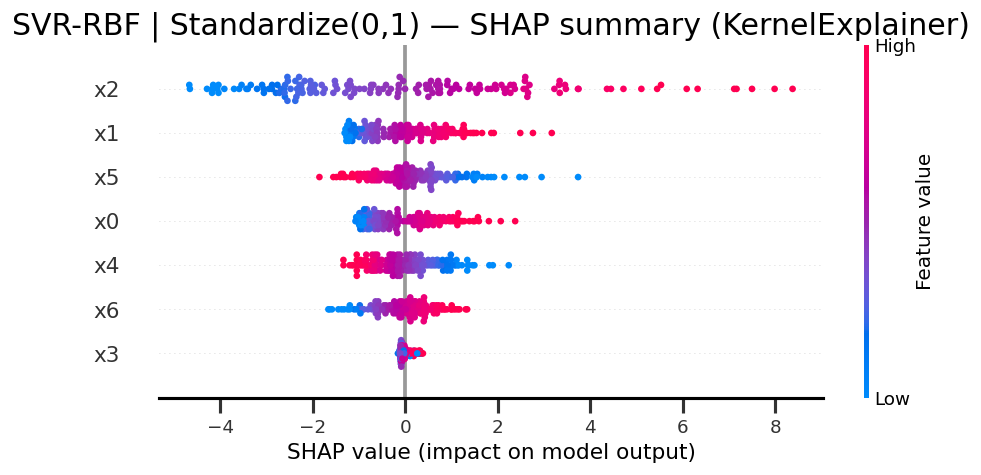

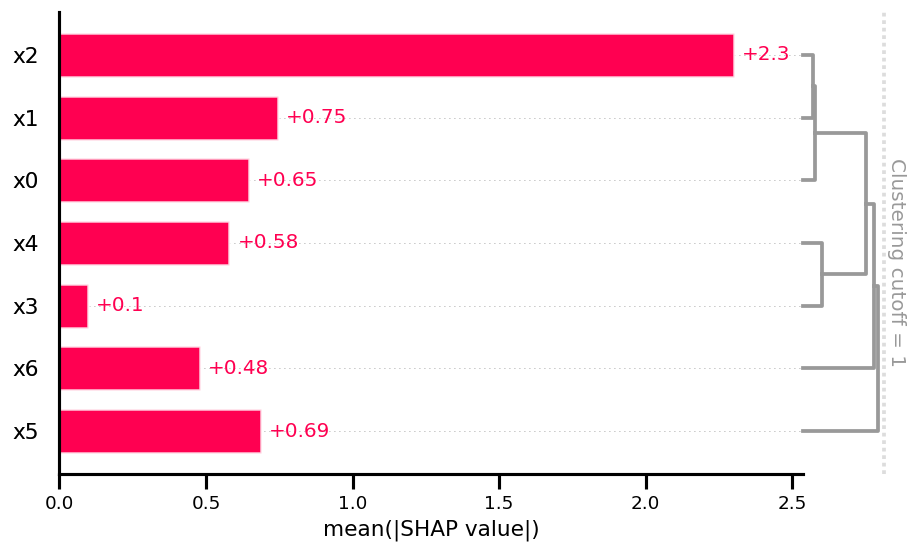

<Figure size 768x576 with 0 Axes>

[SVR-RBF | MinMax[0,1]] TEST: {'R2': 0.1586, 'RMSE': 2.0281, 'MAE': 1.2517}


  0%|          | 0/157 [00:00<?, ?it/s]

/tmp/ipython-input-552720587.py:97: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xte, feature_names=xcols, show=False)


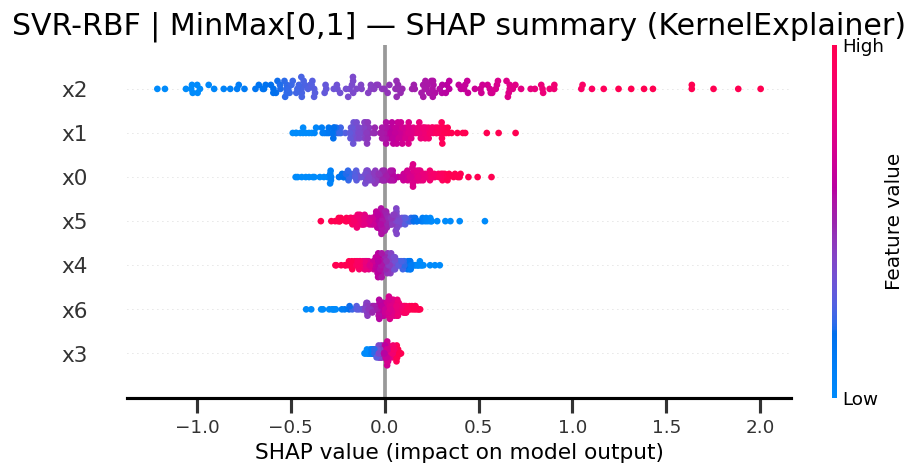

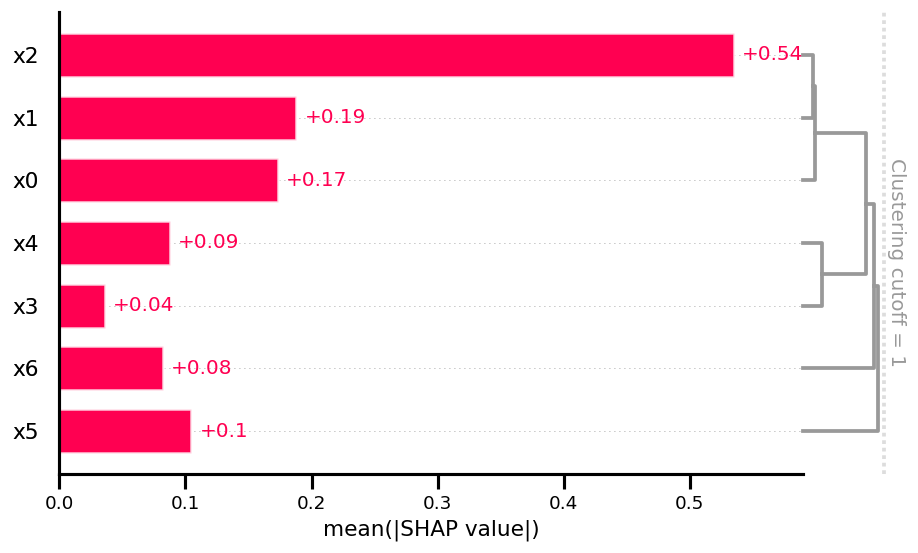

<Figure size 768x576 with 0 Axes>

[SVR-RBF | Raw] TEST: {'R2': 0.9545, 'RMSE': 0.4718, 'MAE': 0.3567}


  0%|          | 0/157 [00:00<?, ?it/s]

/tmp/ipython-input-552720587.py:97: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xte, feature_names=xcols, show=False)


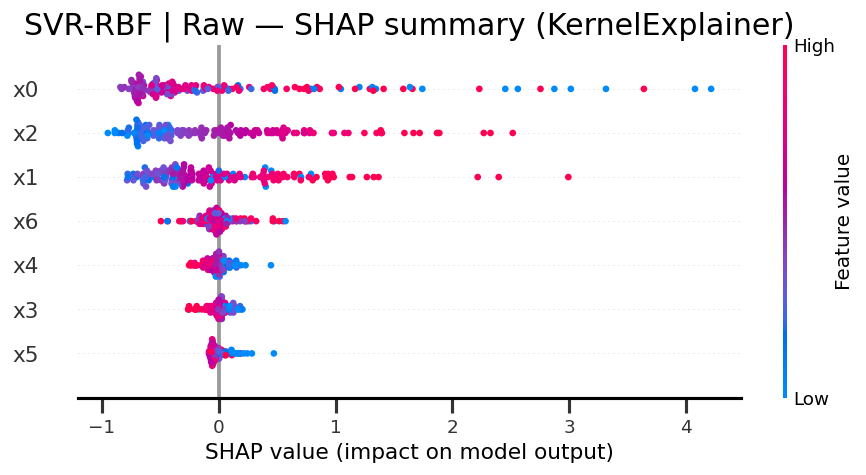

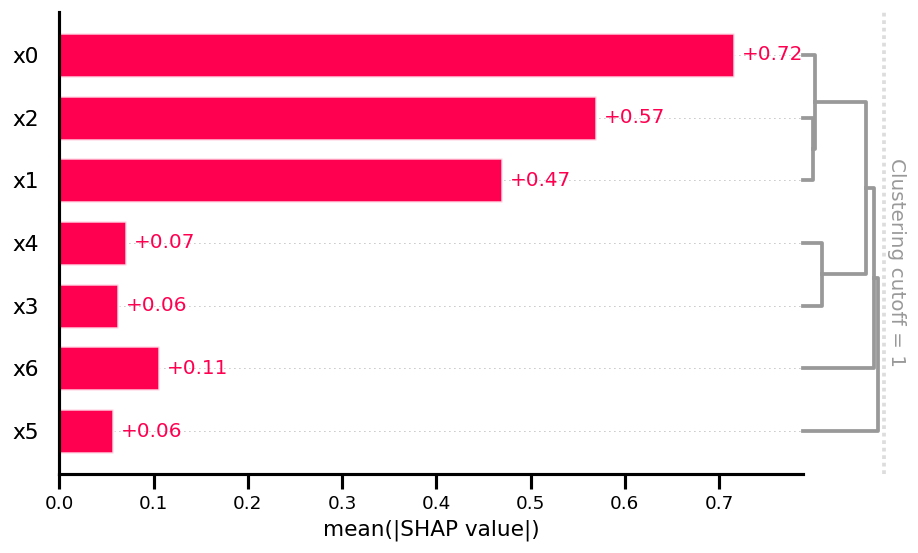

<Figure size 768x576 with 0 Axes>


=== Scaling ablation leaderboard (TEST) ===


,variant,R2,RMSE,MAE
2,Raw,0.954473,0.471778,0.356723
1,"MinMax[0,1]",0.158636,2.028128,1.251726
0,"Standardize(0,1)",-2.291242,4.011284,2.860650


In [ ]:
def _build_linkage_full(X_train, y_train=None):
    try:
        return shap.utils.hclust(X_train, y_train)
    except TypeError:
        return shap.utils.hclust(X_train, metric="correlation")

def scaling_ablation_on_model(
    Xtr, Xte, ytr, yte, xcols, *,
    model_kind="SVR-RBF",
    nsamples_kernel=80,
    refit_hyperparams=False,
    random_state=7
):
    assert model_kind in ["SVR-RBF", "Ridge", "MLP"], "Use 'SVR-RBF', 'Ridge', or 'MLP'."

    results = []
    from sklearn.pipeline import Pipeline

    if model_kind == "SVR-RBF":
        base = SVR(kernel="rbf")
        pipes = {
            "Standardize(0,1)": Pipeline([("scaler", StandardScaler()), ("m", base)]),
            "MinMax[0,1]":      Pipeline([("scaler", MinMaxScaler()), ("m", base)]),
            "Raw":              Pipeline([("m", SVR(kernel="rbf"))])
        }
        default_params = {"m__C": 10.0, "m__gamma": 0.01, "m__epsilon": 0.1}
        search_space = {
            "m__C": np.logspace(-2, 3, 30),
            "m__gamma": np.logspace(-4, 1, 30),
            "m__epsilon": np.logspace(-3, 0, 15),
        }

    elif model_kind == "Ridge":
        base = Ridge(random_state=random_state)
        pipes = {
            "Standardize(0,1)": Pipeline([("scaler", StandardScaler()), ("m", base)]),
            "MinMax[0,1]":      Pipeline([("scaler", MinMaxScaler()), ("m", base)]),
            "Raw":              Pipeline([("m", Ridge(random_state=random_state))])
        }
        default_params = {"m__alpha": 1.0}
        search_space = {"m__alpha": np.logspace(-4, 3, 50)}

    else:  # MLP
        base = MLPRegressor(max_iter=800, early_stopping=True, random_state=random_state)
        pipes = {
            "Standardize(0,1)": Pipeline([("scaler", StandardScaler()), ("m", base)]),
            "MinMax[0,1]":      Pipeline([("scaler", MinMaxScaler()), ("m", base)]),
            "Raw":              Pipeline([("m", MLPRegressor(max_iter=800, early_stopping=True, random_state=random_state))])
        }
        default_params = {"m__hidden_layer_sizes": (128,64), "m__alpha": 1e-4, "m__learning_rate_init": 1e-3}
        search_space = {
            "m__hidden_layer_sizes": [(64,64),(128,64),(128,128)],
            "m__alpha": np.logspace(-6, -2, 7),
            "m__learning_rate_init": np.logspace(-4, -2, 5)
        }

    # Set defaults
    for name, pipe in pipes.items():
        pipe.set_params(**default_params)
        pipe.fit(Xtr, ytr)

    # Optional re-tune per scaler
    if refit_hyperparams:
        cv = KFold(n_splits=4, shuffle=True, random_state=random_state)
        for name, pipe in pipes.items():
            rs = RandomizedSearchCV(pipe, param_distributions=search_space, n_iter=25, cv=cv,
                                    scoring="r2", n_jobs=-1, random_state=random_state, verbose=0, refit=True)
            rs.fit(Xtr, ytr)
            pipes[name] = rs.best_estimator_
            print(f"{model_kind} @ {name}: re-tuned best CV R2={rs.best_score_:.3f}")

    # Evaluate + SHAP
    link = _build_linkage_full(np.vstack([Xtr, Xte]))

    for name, pipe in pipes.items():
        yhat = pipe.predict(Xte)
        s = _scores(yte, yhat); s["variant"] = name
        results.append(s)
        print(f"[{model_kind} | {name}] TEST: { {k:round(s[k],4) for k in ['R2','RMSE','MAE']} }")

        try:
            model_cls = pipe.named_steps["m"].__class__.__name__.lower() if isinstance(pipe, Pipeline) else pipe.__class__.__name__.lower()
            if "ridge" in model_cls:
                scaler = pipe.named_steps.get("scaler", None)
                Xtr_s = scaler.transform(Xtr) if scaler is not None else Xtr
                Xte_s = scaler.transform(Xte) if scaler is not None else Xte
                explainer = shap.LinearExplainer(pipe.named_steps["m"], Xtr_s, feature_names=xcols)
                sv = explainer.shap_values(Xte_s)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{model_kind} | {name} — SHAP summary (LinearExplainer)"); plt.tight_layout(); plt.show()
                ex = _to_explanation(sv, Xte, xcols)
            else:
                f = (lambda XR: pipe.predict(XR))
                bg = Xtr if len(Xtr) <= 200 else Xtr[np.random.choice(len(Xtr), 200, replace=False)]
                explainer = shap.KernelExplainer(f, bg)
                sv = explainer.shap_values(Xte, nsamples=nsamples_kernel)
                shap.summary_plot(sv, Xte, feature_names=xcols, show=False)
                plt.title(f"{model_kind} | {name} — SHAP summary (KernelExplainer)"); plt.tight_layout(); plt.show()
                ex = _to_explanation(sv, Xte, xcols)

            _clustered_bar(ex, link, title=f"{model_kind} | {name} — Clustered SHAP bar", cutoff=1.0)
        except Exception as e:
            print(f"SHAP failed for {model_kind} | {name}: {e}")

    df_res = pd.DataFrame(results).sort_values("R2", ascending=False)
    print("\n=== Scaling ablation leaderboard (TEST) ===")
    display(df_res[["variant","R2","RMSE","MAE"]])

# Run an ablation (edit args below)
scaling_ablation_on_model(
    Xtr, Xte, ytr, yte, xcols,
    model_kind="SVR-RBF",      # "SVR-RBF", "Ridge", "MLP"
    nsamples_kernel=80,
    refit_hyperparams=False
)


## Notes for users

- **Feature correlations matter.** See how SHAP’s clustered bar groups correlated predictors.
- **Scaling can change** margin geometry → **SHAP patterns & PD overlays** can shift in scaled units.
- **Validate stability**: rerun with different seeds, compare across models, and check if feature rankings persist.
- **Optional extensions**: add your own models, swap the target kind (`linear`, `interaction`, `symbolic`), or make features more/less correlated (`rhos`).
